In [30]:
import atlite
import matplotlib.pyplot as plt
from scipy.ndimage import label
import math 
import numpy as np
import json 
import pickle
import os  
import geopandas as gpd
from rasterio.plot import show  
from atlite.gis import shape_availability
import rasterio
from rasterio.transform import Affine
import yaml
from unidecode import unidecode
from utils.data_preprocessing import clean_region_name

dirname = os.getcwd() 
#main_dir = os.path.join(dirname, '..')
with open(os.path.join("configs/config_innermongolia.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader) 

In [31]:
region_name = config['region_name'] #if country is studied, then use country name
region_name = clean_region_name(region_name)


region_folder_name = config['region_folder_name']

resampled = '_resampled' 

EPSG_custom = config['EPSG_manual']


dirname = os.getcwd() 
data_path = os.path.join(dirname, 'data', region_folder_name)
data_from_DEM = os.path.join(data_path, 'derived_from_DEM')

# Load the json EPSG code for the country
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)
#use custom EPSG instead of local UTM zone if wanted
if EPSG_custom:
    EPSG=int(EPSG_custom)

print(f'EPSG {EPSG}')


#path to file and check if it exists and save 1 or 0 for later
landcoverPath=os.path.join(data_path, f'landcover_{config['landcover_source']}_{region_name}_EPSG{EPSG}.tif')
landcover=0 if not os.path.isfile(landcoverPath) and print('no landcover file') is None else 1
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
dem=0 if not os.path.isfile(demRasterPath) and print('no DEM file') is None else 1
slopeRasterPath = os.path.join(data_from_DEM, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
slope=0 if not os.path.isfile(slopeRasterPath) and print('no slope file') is None else 1
windRasterPath = os.path.join(data_path, f'wind_{region_name}_EPSG{EPSG}{resampled}.tif')
wind=0 if not os.path.isfile(windRasterPath) and print('no wind file') is None else 1
solarRasterPath = os.path.join(data_path, f'solar_{region_name}_EPSG{EPSG}{resampled}.tif')
solar=0 if not os.path.isfile(solarRasterPath) and print('no solar file') is None else 1

regionPath =os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region = gpd.read_file(regionPath)

northfacingRasterPath = os.path.join(data_from_DEM, f'north_facing_{region_name}_EPSG{EPSG}{resampled}.tif')
nfacing=0 if not os.path.isfile(northfacingRasterPath) and print('no north facing pixels file') is None else 1
coastlinesPath = os.path.join(data_path, f'goas_{region_name}_{EPSG}.gpkg')
coastlines=0 if not os.path.isfile(coastlinesPath) and print('no coastlines file') is None else 1
protectedAreasPath = os.path.join(data_path, f'protected_areas_{config['consider_protected_areas']}_{region_name}_{EPSG}.gpkg')
protectedAreas=0 if not os.path.isfile(protectedAreasPath) and print('no protected areas file') is None else 1
#OSM
roadsPath = os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.gpkg')
roads=0 if not os.path.isfile(roadsPath) and print('no roads file') is None else 1
railwaysPath = os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.gpkg')
railways=0 if not os.path.isfile(railwaysPath) and print('no railways file') is None else 1
airportsPath = os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.gpkg')
airports=0 if not os.path.isfile(airportsPath) and print('no airports file') is None else 1
waterbodiesPath = os.path.join(data_path, f'OSM_waterbodies_{region_name}_{EPSG}.gpkg')
waterbodies=0 if not os.path.isfile(waterbodiesPath) and print('no waterbodies file') is None else 1
militaryPath = os.path.join(data_path, f'OSM_military_{region_name}_{EPSG}.gpkg')
military=0 if not os.path.isfile(militaryPath) and print('no military file') is None else 1

EPSG 32650


In [28]:
#load unique land use codes
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'r') as fp:
    landuses = json.load(fp)

#load pixel size
if not EPSG==4326:
    with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'r') as fp:
        res = json.load(fp)
else:
    res = 0.0009920634920634887558 #???? res for 4326

#load landcover transform
# with open(os.path.join(data_path, f'transform_landcover_{region_name}_{EPSG}.json'), 'r') as fp:
#     transform_landcover = json.load(fp)
# transform_landcover = Affine(*transform_landcover)

print(landuses)
print(len(landuses))
print(res)
#transform_landcover

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
11
1000.0


In [29]:
region.geometry.item().area/1e6 #km²

1158935.0075402309

# Set your exclusions

In [32]:
#raster can be in different CRS than exclusioncontainer, it is co-registered by atlite!
#vector data needs to be in CRS of exclusioncontainer???

info_list_exclusion = []

#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#add landcover exclusions
excluder.add_raster(landcoverPath, codes=config['landcover_without_buffer'],crs=EPSG)
info_list_exclusion.append(f'landcover codes without buffer which are excluded: {config['landcover_without_buffer']}')
if config['landcover_with_buffer'] is not None: #check if list has entries
    for key, value in config['landcover_with_buffer'].items():
        excluder.add_raster(landcoverPath, codes=key, buffer=value ,crs=EPSG)
    info_list_exclusion.append(f'landcover codes with buffer which are excluded: {config['landcover_with_buffer']}')

#add elevation exclusions
if dem==1 and config['max_elevation'] is not None: 
    excluder.add_raster(demRasterPath, codes=range(config['max_elevation'],10000), crs=EPSG)
    info_list_exclusion.append(f'max elevation: {config['max_elevation']}')
else: print('DEM file not found or not selected in config.')

#add slope exclusions
if slope==1 and config['max_slope'] is not None: 
    excluder.add_raster(slopeRasterPath, codes=range(config['max_slope'],90), crs=EPSG)
    info_list_exclusion.append(f'max slope: {config['max_slope']}')
else: print('Slope file not found or not selected in config.')

#add north facing exclusion
if nfacing==1  and config['north_facing_pixels'] is not None: 
    excluder.add_raster(northfacingRasterPath, codes=1, crs=EPSG)
    info_list_exclusion.append(f'north facing pixels')
else: print('North-facing file not found or not selected in config.')

#add wind exclusions
def code_filter(mask):
    return mask < config['min_wind_speed'] #min desired windspeed 
if wind==1 and config['wind_speed'] is not None: 
    excluder.add_raster(windRasterPath, codes=code_filter, crs=EPSG)
    info_list_exclusion.append(f'min wind speed: {config['min_wind_speed']}')
else: print('Wind file not found or not selected in config.')

#add solar exclusions
def code_filter(mask):
    return mask < config['min_solar_production'] #min desired yearly, specific solar production (kWh/kW) 
if solar==1 and config['solar_production'] is not None: 
    excluder.add_raster(solarRasterPath, codes=code_filter, crs=EPSG)
    info_list_exclusion.append(f'min solar production: {config['min_solar_production']}')
else: print('Solar file not found or not selected in config.')

#add exclusions from vector data
if railways==1 and config['railways_buffer'] is not None: 
    excluder.add_geometry(railwaysPath, buffer=config['railways_buffer'])
    info_list_exclusion.append(f'railways buffer: {config['railways_buffer']}')
else: print('Railways file not found or not selected in config.')

if roads==1 and config['roads_buffer'] is not None: 
    excluder.add_geometry(roadsPath, buffer=config['roads_buffer'])
    info_list_exclusion.append(f'roads buffer: {config['roads_buffer']}')
else: print('Roads file not found or not selected in config.')

if airports==1 and config['airports_buffer'] is not None: 
    excluder.add_geometry(airportsPath, buffer=config['airports_buffer'])
    info_list_exclusion.append(f'airports buffer: {config['airports_buffer']}')
else: print('Airports file not found or not selected in config.')

if waterbodies==1 and config['waterbodies_buffer'] is not None: 
    excluder.add_geometry(waterbodiesPath, buffer=config['waterbodies_buffer'])
    info_list_exclusion.append(f'waterbodies buffer: {config['waterbodies_buffer']}')
else: print('Waterbodies file not found or not selected in config.')

if military==1 and config['military_buffer'] is not None: 
    excluder.add_geometry(militaryPath, buffer=config['military_buffer'])
    info_list_exclusion.append(f'military buffer: {config['military_buffer']}')
else: print('Military file not found or not selected in config.')

if coastlines==1 and config['coastlines_buffer'] is not None: 
    excluder.add_geometry(coastlinesPath, buffer=config['coastlines_buffer'])
    info_list_exclusion.append(f'coastlines buffer: {config['coastlines_buffer']}')
else: print('Coastlines file not found or not selected in config.')

if protectedAreas==1 and config['protectedAreas_buffer'] is not None: 
    excluder.add_geometry(protectedAreasPath, buffer=config['protectedAreas_buffer'])
    info_list_exclusion.append(f'protected areas buffer: {config['railways_buffer']}')
else: print('Protected Areas file not found or not selected in config.')

#calculate available areas
masked, transform = shape_availability(region.geometry, excluder)

eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area
print()
print(f"The eligibility share is: {eligible_share:.2%}")

print()
print('following data was considered during exclusion:')
for item in info_list_exclusion:
    print('- ', item)

DEM file not found or not selected in config.
Slope file not found or not selected in config.
North-facing file not found or not selected in config.
Wind file not found or not selected in config.
Solar file not found or not selected in config.
Railways file not found or not selected in config.
Roads file not found or not selected in config.
Airports file not found or not selected in config.
Waterbodies file not found or not selected in config.
Military file not found or not selected in config.
Coastlines file not found or not selected in config.
Protected Areas file not found or not selected in config.


c:\Users\b396636\AppData\Local\anaconda3\envs\lava_test\Lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:



The eligibility share is: 99.58%

following data was considered during exclusion:
-  landcover codes without buffer which are excluded: [50]


<Axes: title={'center': 'Eligible area (green) 99.58%'}>

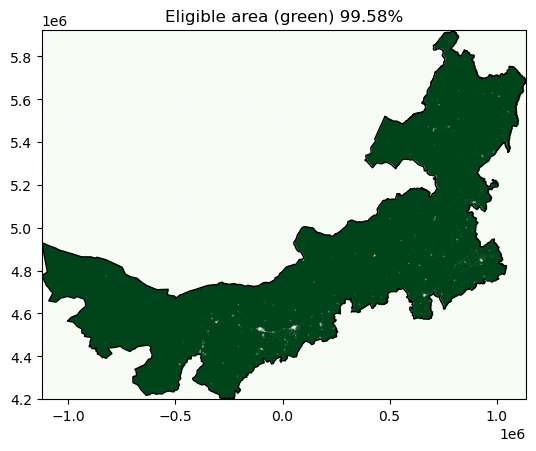

In [33]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(region)

In [34]:
#area filter
def area_filter(boolean_array, min_size):
    # Label connected components in the array
    labeled_array, num_features = label(boolean_array)
    
    # Count the number of pixels in each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create a mask for components that meet the size requirement (ignoring the background)
    large_component_mask = np.zeros_like(component_sizes, dtype=bool)
    large_component_mask[1:] = component_sizes[1:] >= min_size  # Skip the background component (index 0)
    
    # Filter the original array, keeping only large components
    filtered_array = large_component_mask[labeled_array]
    
    return filtered_array

In [35]:
min_pixels_connected = config['min_pixels_connected']
min_pixels_x=config['min_pixels_x']
min_pixels_y=config['min_pixels_y']

masked_area_filtered = area_filter(masked,min_size=min_pixels_connected)
#masked_area_filtered = area_filter2(masked,min_x=5, min_y=5)

#array to be used 
array = masked_area_filtered

# Convert boolean array to integers (1 for True, 0 for False)
int_array = array.astype(np.uint8)

# Set 0 (False) to be the nodata value
nodata_value = 0

#save eligible land array as .tif file
# Define the metadata for the new file
# You'll need to adjust these parameters based on your specific data
metadata = {
    'driver': 'GTiff',
    'dtype': rasterio.uint8,
    'nodata': nodata_value,
    'width': array.shape[1],
    'height': array.shape[0],
    'count': 1,
    'crs': rasterio.crs.CRS.from_epsg(EPSG),  # WGS84, modify as needed
    'transform': transform,
    'compress': 'LZW' 
}

# Write the array to a new .tif file
if masked_area_filtered in array:
    with rasterio.open(os.path.join(data_path, f'available_land_filtered-min{min_pixels_connected}_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)
else:
    with rasterio.open(os.path.join(data_path, f'available_land_total_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)    